# Sales Analysis

Shenyue Jia

## About the data

- The salary data for data scientist is collected and prepared by [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/).

### Data dictionary

Variable Name  | Description
-------------------|------------------
Item_Identifier	| Unique product ID
Item_Weight	| Weight of product
Item_Fat_Content	| Whether the product is low fat or regular
Item_Visibility	| The percentage of total display area of all products in a store allocated to the particular product
Item_Type	| The category to which the product belongs
Item_MRP	| Maximum Retail Price (list price) of the product
Outlet_Identifier	| Unique store ID
Outlet_Establishment_Year	| The year in which store was established
Outlet_Size	| The size of the store in terms of ground area covered
Outlet_Location_Type	| The type of area in which the store is located
Outlet_Type	| Whether the outlet is a grocery store or some sort of supermarket
Item_Outlet_Sales	| Sales of the product in the particular store. This is the target variable to be predicted.

## Analysis preparation

### Imports

In [1]:
# data wrangling & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import joblib

### Load data

In [2]:
df = pd.read_csv('Data/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Check and treat missing data

In [3]:
# Display the sum of missing values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [4]:
# display the percentage of missing values by column
print(df.isna().sum()/len(df)*100)

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64


- `Item_Weight` has ~14.16% missing value
- Removing all of them is not a good idea as the % of missing data exceeds the 2% threshold
- We will replace the missing value with average by groups of `Item_Type`

In [5]:
# return unique values as a dictionary
replace_values = df.groupby('Item_Type')['Item_Weight'].mean().round(2).to_frame('Mean').reset_index()
replace_values.head()

,Item_Type,Mean
0,Baking Goods,12.28
1,Breads,11.35
2,Breakfast,12.77
3,Canned,12.31
4,Dairy,13.43


In [6]:
## create a function to fill the missing value from a look-up table
# loop over rows with missing values to fill
def match_to_fill(df, replace_values, missing_col, group_col, na_rows, stat_type):
  for i in na_rows:
    match_col_val = df.loc[i,group_col]
    
    match_result = replace_values[stat_type].loc[replace_values[group_col] == match_col_val].item()
    df.at[i, missing_col] = match_result

In [7]:
# assign col name with missing values and col names as a joint field to find 
# matched values to fill the missing values
missing_col = 'Item_Weight'
group_col = 'Item_Type'
stat_type = 'Mean'
# calculate the row index for rows with missing values
na_rows = df[df[missing_col].isna()].index
na_rows

Int64Index([   7,   18,   21,   23,   29,   36,   38,   39,   49,   59,
            ...
            8458, 8463, 8469, 8472, 8480, 8485, 8487, 8488, 8490, 8504],
           dtype='int64', length=1463)

In [8]:
# call the function to fill missing values
match_to_fill(df, replace_values, missing_col, group_col, na_rows, stat_type)

In [9]:
# check if missing value exists in Region column
df['Item_Weight'].isnull().sum()

0

- The `Outlet_Size` field is related to the size of the sellers of products, such as grocery stores, supermarkets, etc.
- We can compare several key measurements of the outlet, such as `Outlet_Location_Type`, `Outlet_Location_Type`, and `Item_Outlet_Sales` to see if we can make some judgement on what kind of outlets they may be.

In [10]:
# check what kind of data have missing values
nullRowsOutletSize = df[df['Outlet_Size'].isna()]
nullRowsOutletSize[['Item_Visibility','Outlet_Location_Type','Outlet_Type','Item_Outlet_Sales']].round(2)

,Item_Visibility,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,0.00,Tier 3,Grocery Store,732.38
8,0.02,Tier 2,Supermarket Type1,1076.60
9,0.09,Tier 2,Supermarket Type1,4710.54
25,0.10,Tier 2,Supermarket Type1,838.91
28,0.16,Tier 3,Grocery Store,178.43
...,...,...,...,...
8502,0.07,Tier 2,Supermarket Type1,3020.07
8508,0.04,Tier 2,Supermarket Type1,2587.96
8509,0.21,Tier 3,Grocery Store,424.78
8514,0.05,Tier 2,Supermarket Type1,468.72


- We can calculate descriptive stats of the rows with missing values of `Outlet_Size` and check how similar they are with other rows in the dataset.

In [11]:
nullRowsOutletSize.groupby(['Outlet_Location_Type']).median(numeric_only=True).round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Outlet_Location_Type,,,,,
Tier 2,12.5,0.05,141.92,2002.0,1946.80
Tier 3,12.6,0.09,143.91,1998.0,250.34


In [12]:
# check the basic characteristics all data
df.groupby(['Outlet_Location_Type','Outlet_Size']).median(numeric_only=True).round(2)

Item_Weight  Item_Visibility  Item_MRP  \
Outlet_Location_Type Outlet_Size                                           
Tier 1               Medium             12.65             0.05    141.82   
                     Small              12.99             0.06    143.81   
Tier 2               Small              12.55             0.05    145.98   
Tier 3               High               12.85             0.05    142.05   
                     Medium             12.99             0.05    142.02   

                                  Outlet_Establishment_Year  Item_Outlet_Sales  
Outlet_Location_Type Outlet_Size                                                
Tier 1               Medium                          1999.0            1966.11  
                     Small                           1997.0            1040.65  
Tier 2               Small                           2004.0            2109.25  
Tier 3               High                            1987.0            2050.66  
                     Medium                          1985.0            2350.94

- There is no Tier 1 outlets in the `nullRowsOutletSize` dataframe. We can compare how similar the spects are in these values compared with the **Small** `Outlet_Size` in all our data.

- Among all the numeric metrics, the `Item_Outlet_Sales` would be a good one to distinguish different types of `Outlet_Size` than other options we have here.

- Median `Item_Outlet_Sales` **Tier 2 Small** outlets is `2109.25`, greater than the median `Item_Outlet_Sales` of **Tier 2** outlets in `nullRowsOutletSize` (`1946.80`).

- For **Tier 3** outlets without `Outlet_Size`, they have a much smaller `Item_Outlet_Sales` than the **Tier 3 High** and **Tier 3 Medium** types (`250.34` vs. above `2000`. So we can consider assigning these rows to **Small** size as well.

- We can compare the `mean` option to see if the same pattern persists.


In [13]:
# null rows mean
nullRowsOutletSize.groupby(['Outlet_Location_Type']).mean(numeric_only=True).round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Outlet_Location_Type,,,,,
Tier 2,12.74,0.06,140.19,2004.5,2266.41
Tier 3,12.91,0.10,140.78,1998.0,339.35


In [14]:
# all data mean
df.groupby(['Outlet_Location_Type','Outlet_Size']).mean(numeric_only=True).round(2)

Item_Weight  Item_Visibility  Item_MRP  \
Outlet_Location_Type Outlet_Size                                           
Tier 1               Medium             12.92             0.06    140.30   
                     Small              12.87             0.08    141.24   
Tier 2               Small              12.83             0.06    143.12   
Tier 3               High               13.01             0.06    141.43   
                     Medium             12.86             0.06    140.74   

                                  Outlet_Establishment_Year  Item_Outlet_Sales  
Outlet_Location_Type Outlet_Size                                                
Tier 1               Medium                         1999.00            2348.35  
                     Small                          1992.65            1576.19  
Tier 2               Small                          2004.00            2438.84  
Tier 3               High                           1987.00            2299.00  
                     Medium                         1996.95            2847.96

- Mean of `Item_Outlet_Sales` **Tier 2 Small** outlets is `2438.84`, greater than the mean of `Item_Outlet_Sales` of **Tier 2** outlets in `nullRowsOutletSize` (`2266.41`). This is persistent as we have observed in the median for **Tier 2** outlets.
- **Tier 3** outlets also preserve the same pattern.

Therefore, we can assign the `Outlet_Size` of rows with

*   `'Outlet_Location_Type' == 'Tier 2'` to `Small`
*   `'Outlet_Location_Type' == 'Tier 3'` to `Small`

In [15]:
df.loc[(df['Outlet_Location_Type'] == 'Tier 2') & (df['Outlet_Size'].isna()), 'Outlet_Size'] = 'Small'
df.loc[(df['Outlet_Location_Type'] == 'Tier 3') & (df['Outlet_Size'].isna()), 'Outlet_Size'] = 'Small'

In [16]:
# check if there is still missing values in the dataframe
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Check and fix any inconsistent categories of data

In [17]:
# get columns in object format
data_types = df.dtypes
cols = data_types[data_types=='object'].index
cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [18]:
# print unique values
for col in cols:
 print(f"The unique values of the feature {col} are:\n")
 print(df[col].value_counts())
 print("\n")

The unique values of the feature Item_Identifier are:

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


The unique values of the feature Item_Fat_Content are:

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


The unique values of the feature Item_Type are:

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


The unique values of the 

Here are some discrepancies we found after printing out the unique values for each column.


*   `reg` should be `Regular`
*   `low fat` should be `Low Fat`
*   `LF` should be `Low Fat`

In [19]:
# replace the inconsistent categories
df.replace(to_replace=['LF', 'low fat'], value='Low Fat', inplace=True)
df.replace('reg','Regular', inplace=True)

In [20]:
# show what the column looks like after correction
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

### Drop unnecessary columns

In [21]:
# drop unnecessary columns
df = df.drop(columns = ['Item_Identifier'])
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

## EDA

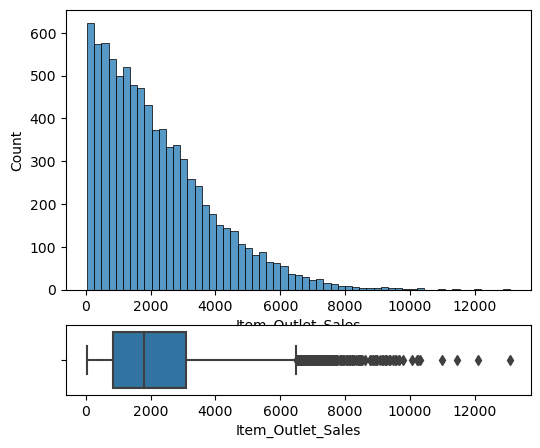

In [22]:
target = 'Item_Outlet_Sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=df, x=target,ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1]);

fig.savefig('PNG/EDA-item-outlet-sales.png',dpi=300)

## Functions and setup for machine learning models

### Setting random state for reproducibility

In [23]:
SEED = 321
np.random.seed(SEED)

### Visualization setup

In [24]:
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

### `evaluate_regression`

- Evaluate training and test data using R-squared and RMSE.

In [25]:
# for evaluating a regression model using r-squared and RMSE
def evaluate_regression(model, X_train, y_train, X_test, y_test): 
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, squared = False)
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, squared = False)
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

## Preprocessing

### Split train and test

In [26]:
# split X and y, you are predicting price
X = df.drop(columns=['Item_Outlet_Sales']).copy()
y = df['Item_Outlet_Sales'].copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,Small,Tier 3,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1


### Make numeric preprocessing pipeline

In [27]:
## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

### Make categorical preprocessing pipeline

In [28]:
## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

### Make preprocessing column transformer

In [29]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),verbose_feature_names_out = False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13df97e50>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13dc383a0>)],
                  verbose_feature_names_out=False)

### Make X_train_df and X_test_df, dataframe verisons of processed X_train/X_test

In [30]:
# fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_Low Fat',
       'Item_Fat_Content_Regular', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049', 'Outlet_Size_High',
       'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_

In [31]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_train_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220,0.064142,61.2510,1998.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7604,6.135,0.079294,111.2860,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2762,12.150,0.028593,151.0708,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [32]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.25,0.061531,132.2968,2007.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2391,17.85,0.044463,127.1020,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
163,7.27,0.071078,114.2518,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Modeling 1: Linear Regression

### Fit and evaluate a linear regression model using `X_train` and `X_test` dataframes

In [33]:
# apply linear regression and display coefficients using a pre-defined function
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)

LinearRegression()

In [34]:
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1114.97
Test Data:	R^2= 0.56	RMSE= 1164.43


- The model over training data explained 56% of variance in the data. It has an `RMSE` = 1114.97
- The model performed similar over testing data, yielding a slightly larger RMSE than the training data

### Extract and visualize the model coefficients

In [35]:
# a function to obtain coefficients from the model object
# do not include intercept
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
#     coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [36]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                          1.298306
Item_Visibility                   -276.267691
Item_MRP                            15.601635
Outlet_Establishment_Year          -15.776019
Item_Fat_Content_Low Fat           -15.705015
Item_Fat_Content_Regular            15.705015
Item_Type_Baking Goods               9.124580
Item_Type_Breads                    -3.469736
Item_Type_Breakfast                 69.811421
Item_Type_Canned                    22.802504
Item_Type_Dairy                    -49.131463
Item_Type_Frozen Foods              -5.461387
Item_Type_Fruits and Vegetables     15.971692
Item_Type_Hard Drinks               49.695552
Item_Type_Health and Hygiene       -41.649103
Item_Type_Household                -68.900434
Item_Type_Meat                     -15.955669
Item_Type_Others                    17.123647
Item_Type_Seafood                   98.535153
Item_Type_Snack Foods              -11.802683
Item_Type_Soft Drinks             -117.453087
Item_Type_Starchy Foods           

In [37]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [38]:
coeffs.sort_values()

Outlet_Type_Grocery Store         -880.2990
Outlet_Identifier_OUT010          -445.0995
Outlet_Identifier_OUT019          -435.1995
Item_Visibility                   -276.2677
Outlet_Size_Small                 -269.0561
Outlet_Location_Type_Tier 1       -214.7982
Outlet_Identifier_OUT049          -143.8932
Item_Type_Soft Drinks             -117.4531
Outlet_Size_High                   -92.0706
Outlet_Identifier_OUT013           -92.0706
Outlet_Identifier_OUT045           -91.5433
Outlet_Type_Supermarket Type2      -74.3776
Outlet_Identifier_OUT018           -74.3776
Item_Type_Household                -68.9004
Item_Type_Dairy                    -49.1315
Item_Type_Health and Hygiene       -41.6491
Outlet_Location_Type_Tier 3        -32.1502
Item_Type_Meat                     -15.9557
Outlet_Establishment_Year          -15.7760
Item_Fat_Content_Low Fat           -15.7050
Item_Type_Snack Foods              -11.8027
Item_Type_Frozen Foods              -5.4614
Item_Type_Breads                

### Visualize coefficients by importance

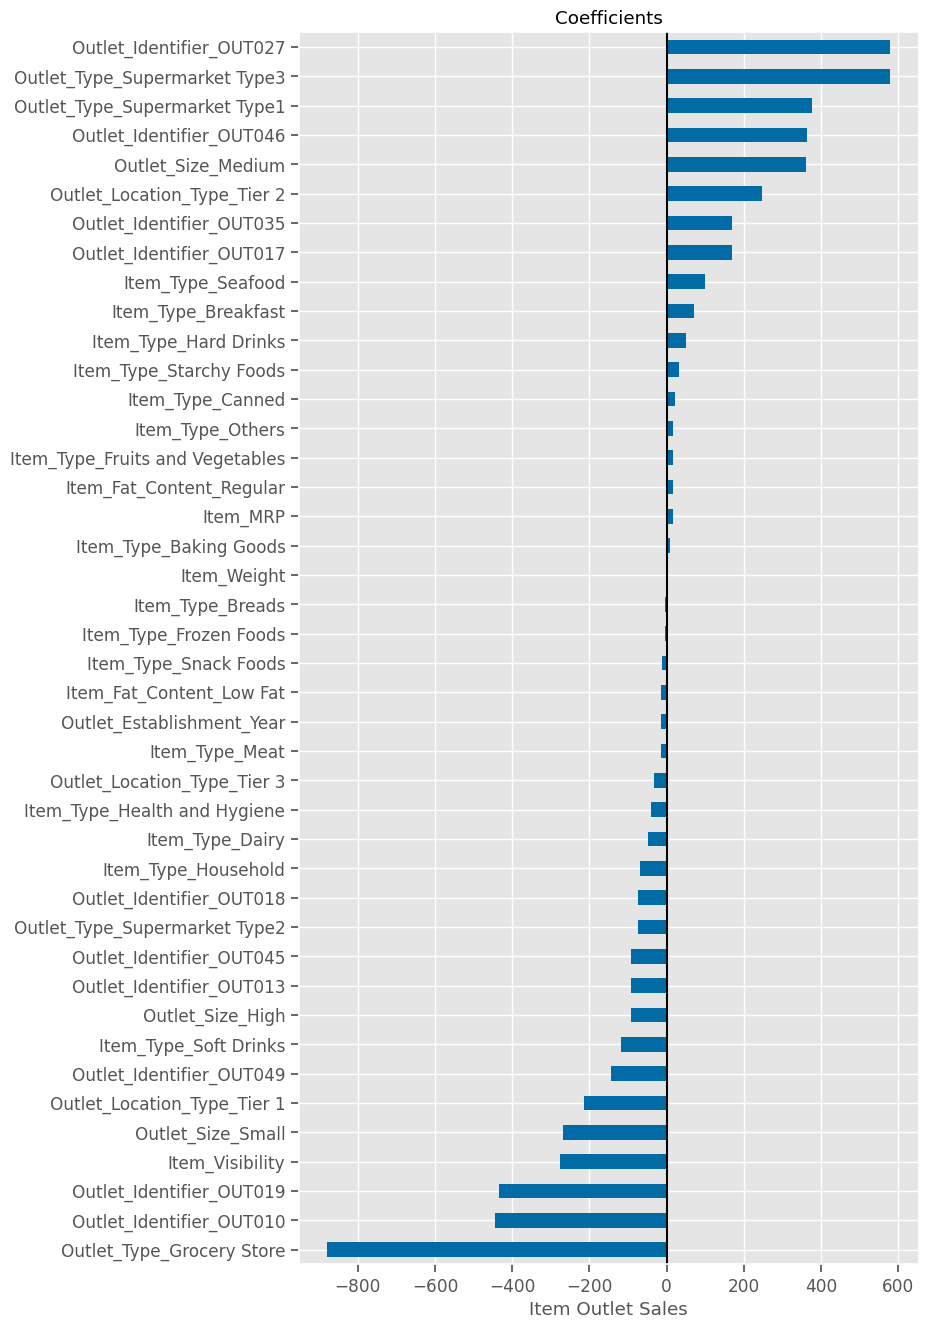

In [39]:
## Plot country ceoffs
ax = coeffs.sort_values().plot(kind='barh', figsize=(8,16))
ax.axvline(0, color='k')
ax.set(xlabel='Item Outlet Sales', title="Coefficients");
plt.savefig('PNG/all-coeffs.png')

- Remove `Outlet_Identifier` features

In [40]:
## Get a list of all of the ohe columsn
outlet_feats = [c for c in X_train_df.columns if c.startswith('Outlet_Identifier')]
len(outlet_feats)

10

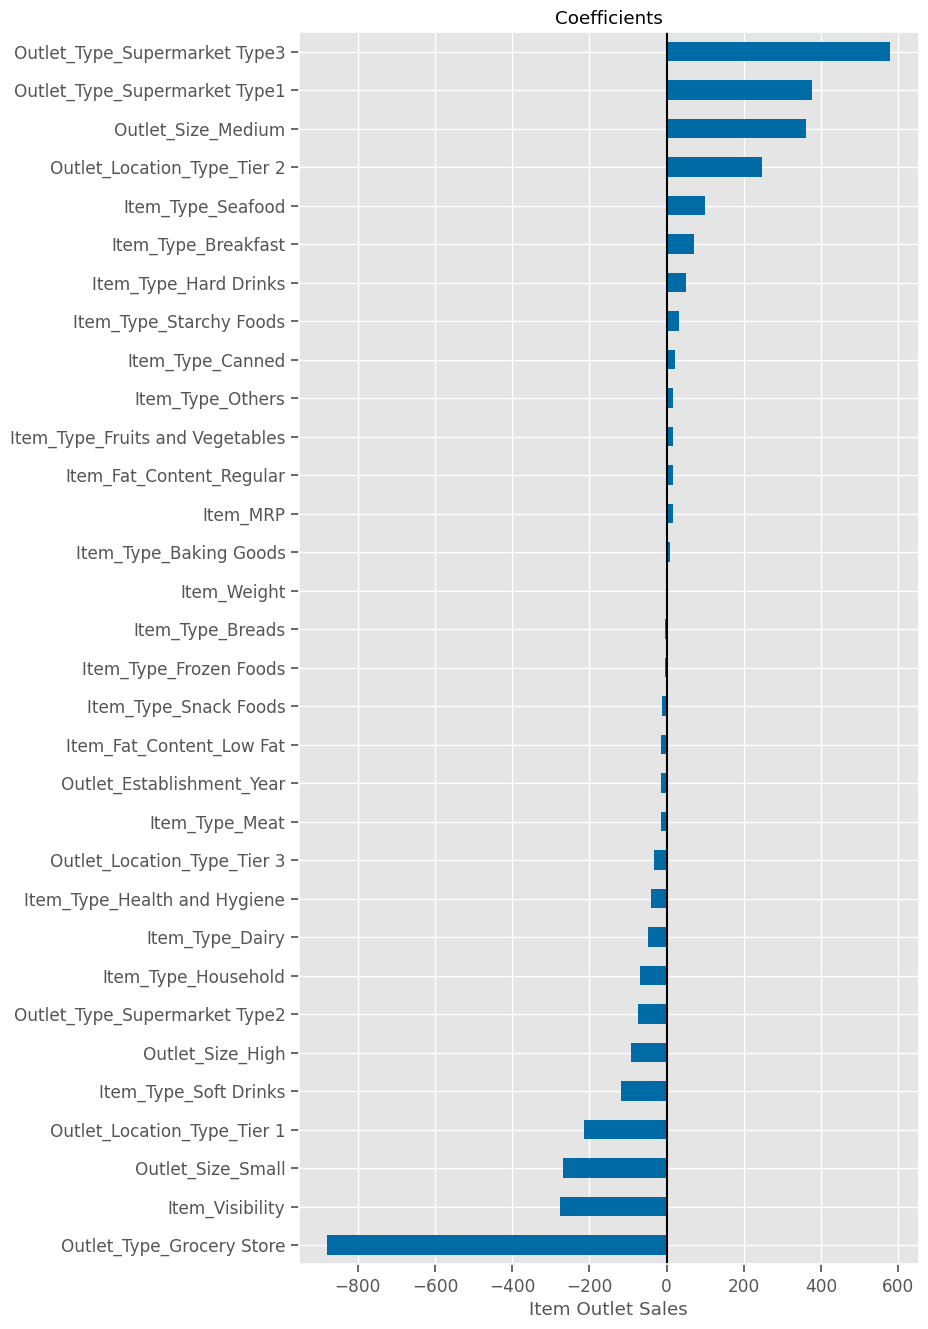

In [41]:
## Plot everything but outlet identifier
ax = coeffs.drop(outlet_feats).sort_values().plot(kind='barh', figsize=(8,16))
ax.axvline(0, color='k')
ax.set(xlabel='Item Outlet Sales', title="Coefficients");
plt.savefig('PNG/coeff-no-outlet-id.png')

### Top 3 most important features

- We excluded the `Outlet_Identifier` features as they are store IDs, with much less meaningful information for a big-picture pattern


In [42]:
coeffs.drop(outlet_feats).sort_values(ascending = False).head(3)

Outlet_Type_Supermarket Type3   579.3975
Outlet_Type_Supermarket Type1   375.2792
Outlet_Size_Medium              361.1267
dtype: float64

1. `Outlet_Type_Supermarket Type3`
    - Being in the Type 3 Supermarket group increases the item outlet sales by 579.3975.
2. `Outlet_Type_Supermarket Type1`
    - Being in the Type 1 Supermarket group increases the item outlet sales by 375.2792.
3. `Outlet_Size_Medium`
    - Being in the Medium Supermarket type increases the item outlet sales by 361.1267.

## Tree-based model

### Fit and evaluate a tree-based model using `X_train` and `X_test` dataframes

In [43]:
dec_tree = DecisionTreeRegressor(random_state = SEED)
dec_tree.fit(X_train_df,y_train)
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.21	RMSE= 1556.79


- The model over training data explained 100% of variance in the data. It has an `RMSE` = 0
- The model explained only 21% of the variance in the data and has an `RMSE` = 1556.79
- The big difference of model performance b/w training and testing data indicates the model made some significant errors in testing data

### Extract and visualize feature importance

- Stil exclude `Outlet_Identifier`

In [44]:
coeffs = pd.Series(dec_tree.feature_importances_, index=feature_names,
                        name='Feature Importances')
coeffs

Item_Weight                       0.0624
Item_Visibility                   0.1034
Item_MRP                          0.4420
Outlet_Establishment_Year         0.0139
Item_Fat_Content_Low Fat          0.0052
Item_Fat_Content_Regular          0.0052
Item_Type_Baking Goods            0.0039
Item_Type_Breads                  0.0017
Item_Type_Breakfast               0.0032
Item_Type_Canned                  0.0062
Item_Type_Dairy                   0.0023
Item_Type_Frozen Foods            0.0041
Item_Type_Fruits and Vegetables   0.0069
Item_Type_Hard Drinks             0.0028
Item_Type_Health and Hygiene      0.0054
Item_Type_Household               0.0050
Item_Type_Meat                    0.0033
Item_Type_Others                  0.0016
Item_Type_Seafood                 0.0012
Item_Type_Snack Foods             0.0084
Item_Type_Soft Drinks             0.0032
Item_Type_Starchy Foods           0.0017
Outlet_Identifier_OUT010          0.0000
Outlet_Identifier_OUT013          0.0013
Outlet_Identifie

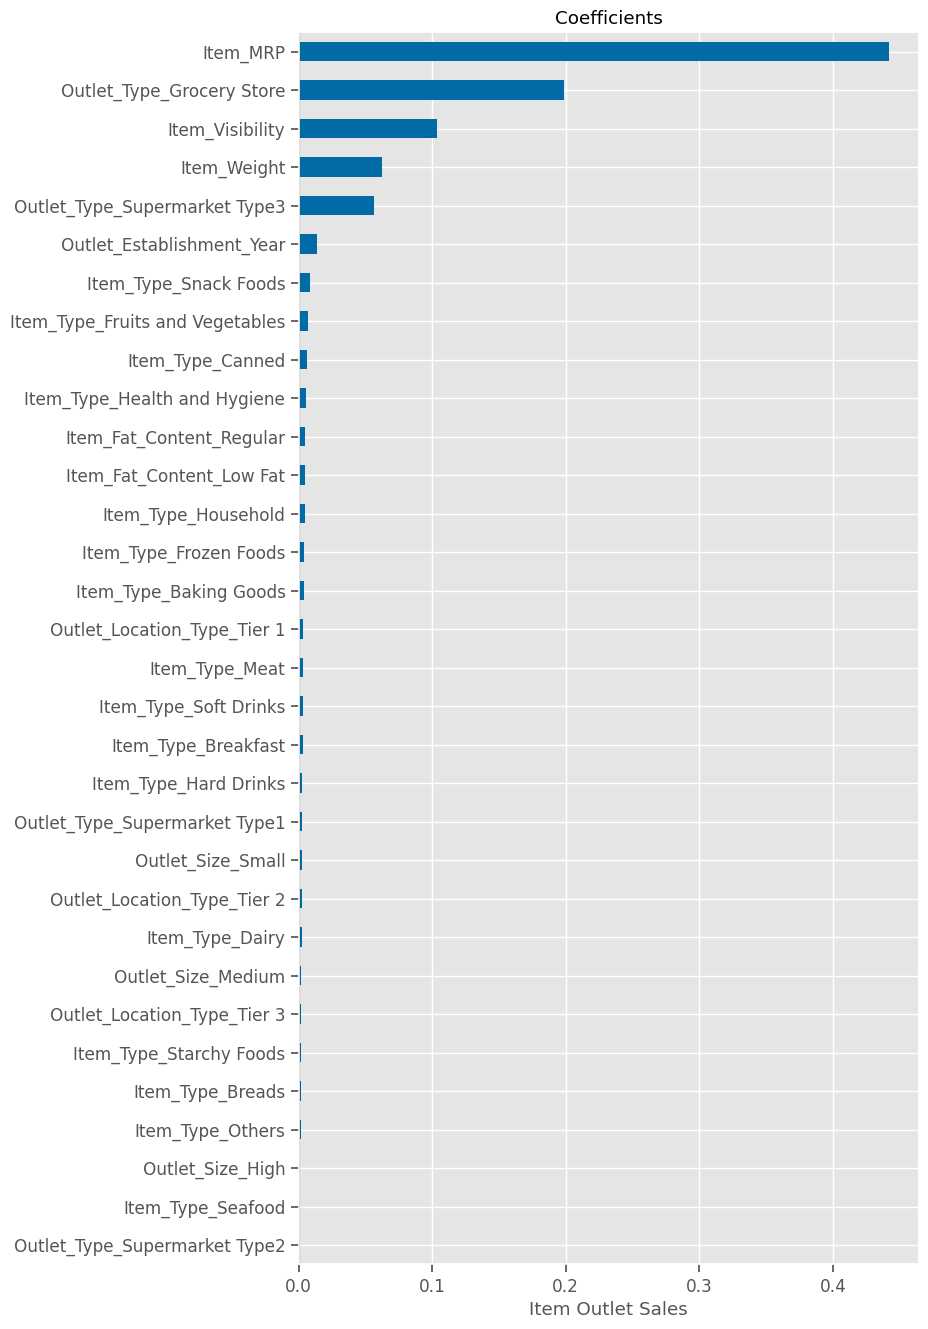

In [45]:
## Plot everything but outlet identifier
ax = coeffs.drop(outlet_feats).sort_values().plot(kind='barh', figsize=(8,16))
ax.axvline(0, color='k')
ax.set(xlabel='Item Outlet Sales', title="Coefficients");
plt.savefig('PNG/coeff-no-outlet-id-dec-tree.png')

### Top 5 most important features

- Exclude `Outlet_Identifier`

In [46]:
coeffs.drop(outlet_feats).sort_values(ascending = False).head(5)

Item_MRP                        0.4420
Outlet_Type_Grocery Store       0.1986
Item_Visibility                 0.1034
Item_Weight                     0.0624
Outlet_Type_Supermarket Type3   0.0563
Name: Feature Importances, dtype: float64

The following five features contribute to the explanation of variance in data the most:
1. `Item_MRP`
    - Maximum retail price labeled on the items
2. `Outlet_Type_Grocery Store`
    - Being the Grocery Store as the type of supermarket
3. `Item_Visibility`
    - The percentage of total display area of all products in a store allocated to the particular product
4. `Item_Weight`
    - Weight of item
5. `Outlet_Type_Supermarket Type3`
    - Being Type 3 of supermarket

## Serialize the Best Models with Joblib

### Save the following values as a dictionary in a joblib file

- `preprocessor`: preprocessing column transformer
- `X_train`: training features.
- `X_test`: test features.
- `y_train`: training target.
- `y_test`: test target.
- `LinearRegression`: best linear regression
- `DecisionTreeRegressor`: best tree-based model

In [47]:
export = {'preprocessor': preprocessor,
          'X_train':X_train_df,
          'y_train': y_train,
          'X_test':X_test_df,
          'y_test': y_test,
          'LinearRegression': lin_reg,
          'DecisionTreeRegressor': dec_tree}
joblib.dump(export, 'best-models.joblib')

['best-models.joblib']